# Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# utils
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite
import shap
from collections import Counter
from tqdm import tqdm
import time
import pickle

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Read Data

In [2]:
train_data_path = "data/processed/sample_train.csv"
test_data_path = "data/processed/sample_test.csv"
vt_train_data_path = "data/virustotal/train_vt_data.csv"
vt_test_data_path = "data/virustotal/test_vt_data.csv"

In [3]:
raw_train = pd.read_csv(train_data_path)
raw_test = pd.read_csv(test_data_path)
vt_train_df = pd.read_csv(vt_train_data_path)
vt_test_df = pd.read_csv(vt_test_data_path)

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


# Feature Engineering

In [4]:
def feature_engineering(input_df, feature_cols_lst,mode='train'):
    df = input_df.copy()
    df['has_debug_relocations_resources_signature']=df['has_debug']*df['has_relocations']*df['has_resources']*df['has_signature']
    # set hash as index and extract feature cols
    df.set_index('sha256', inplace=True)
    df = df[feature_cols_lst + ['label']]
    if mode == 'train':
        # drop duplicates
        df.drop_duplicates(inplace=True)
    return df

In [5]:
feature_cols = ['size', 'vsize',
                'exports', 'imports',
                'has_tls', 'symbols',
                'avlength',
                'printables', 'entropy', 'paths', 'urls',
                'registry',
                'has_debug_relocations_resources_signature']

correlated_cols = ['numstrings', 'MZ'] # we came to the conclusion that we wont use these columns

In [6]:
df_train = feature_engineering(raw_train, feature_cols)
df_test = feature_engineering(raw_test, feature_cols, mode = 'test')

In [7]:
print(f"train original shape: {raw_train.shape}")
print(f"train shape after preprocess: {df_train.shape}")
print(f"test shape: {df_test.shape}")

train original shape: (160000, 23)
train shape after preprocess: (147776, 14)
test shape: (120000, 14)


# Dimensionality Reduction

In [8]:
X = df_train[feature_cols].values
y = df_train['label'].values

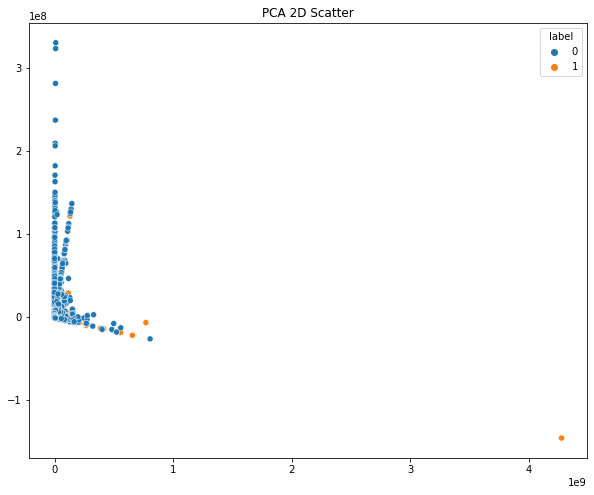

In [9]:
# perform PCA
pca = PCA()
pca.fit(X)
data_pca = pca.transform(X)
# plot the pca 2d scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(x= data_pca[:, 0], y= data_pca[:, 1], hue=df_train['label'])
plt.title('PCA 2D Scatter')
plt.show()

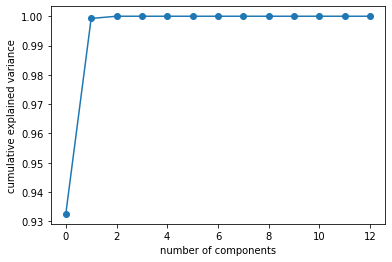

In [10]:
# plot pca cummulative explained variance
var_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cumsum)
plt.scatter(x=range(var_cumsum.shape[0]), y = var_cumsum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Hyper Paramater Tuning

In [11]:
# our models
model_dic = {
    'baseline' : LogisticRegression,
    'xgboost' : xgb.XGBClassifier,
    'random_forest' : RandomForestClassifier,
    'adaboost' : AdaBoostClassifier
}

hp_dic = {
    'baseline' : {'C': [0.1,1,10]},
    'xgboost' : {
        'max_depth': [4,6,8],
        'learning_rate': [0.1,0.3,0.5],
        'n_estimators': [100, 200, 300, 400],
        'gamma': [0, 0.5, 1]
        },

    'random_forest' : {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 3, 20], 
        'min_samples_leaf': [1, 2, 10], 
    },
    'adaboost' : {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01,0.05,0.1,0.3],
    }
}

In [12]:
def get_best_params(models_dic,hp_dic):
    """
    find the best paramaters given models and hyper paramters to search
    models_dic: dictionary of models
    hp_dic: dictionary of hyper parameters
    """
    best_params_dic = {}
    for model in models_dic.keys():
        print(f"starting grid search for {model}")
        start = time.time()
        clf = models_dic[model]()
        clf = RandomizedSearchCV(clf, hp_dic[model], cv=3, scoring='roc_auc', n_jobs=-1)
        clf.fit(X, y)
        best_params_dic[model] = {}
        best_params_dic[model]['params'] = clf.best_params_
        best_params_dic[model]['best_score'] = clf.best_score_
        print(f"finished grid search for {model} in {round(time.time() - start,2)} seconds")
    return best_params_dic

In [13]:
try:
    with open('data/model_results/best_params_dic.pkl', 'rb') as f:
        best_params_dic = pickle.load(f)
except:
    best_params_dic = get_best_params(model_dic,hp_dic)
    with open('data/model_results/best_params_dic.pkl', 'wb') as f:
        pickle.dump(best_params_dic, f)

In [14]:
for model in best_params_dic.keys():
    model_score = round(best_params_dic[model]['best_score'],3)
    print(f"model: {model}, score: {model_score}")
    print(f"best params: {best_params_dic[model]}")

model: baseline, score: 0.381
best params: {'params': {'C': 0.1}, 'best_score': 0.3808487647343253}
model: xgboost, score: 0.93
best params: {'params': {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}, 'best_score': 0.9299447595512108}
model: random_forest, score: 0.849
best params: {'params': {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}, 'best_score': 0.8491494639144043}
model: adaboost, score: 0.844
best params: {'params': {'n_estimators': 300, 'learning_rate': 0.3}, 'best_score': 0.8442698458998293}


# Training

In [15]:
X_train = df_train[feature_cols]
y_train = df_train['label']

In [16]:
# train the best model
start = time.time()
xgb_model = xgb.XGBClassifier(**best_params_dic['xgboost']['params'])
xgb_model.fit(X_train, y_train)
print(f"finished training xgboost in {round(time.time() - start,2)} seconds")

finished training xgboost in 11.62 seconds


In [17]:
# define the dataset
dc_train = Dataset(df_train, label = 'label', cat_features= [])
dc_test = Dataset(df_test, label = 'label', cat_features= [])
# define checks object
suite = full_suite()

In [58]:
suite.run(train_dataset = dc_train, test_dataset = dc_test, model = xgb_model)

Full Suite: 
 
 
 
 35/35 [Time: 01:27, Check=Identifier Label Correlation]

Accordion(children=(VBox(children=(HTML(value='\n            <h1 id="summary_0NH36LXBJGXV24NH9Q4JJL57Y">Full S…

# Results

### Train

In [62]:
y_pred = xgb_model.predict_proba(X_train)[:, 1]
plot_precision_recall_acc_curve(y_train, y_pred, 'Train',800,600)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [61]:
plot_pred_dist(y_train, y_pred,800,600)

In [19]:
X_test = df_test[feature_cols]
y_test = df_test['label']

In [55]:
# get the predictions
y_pred = xgb_model.predict_proba(X_test)[:, 1]
plot_precision_recall_acc_curve(y_test, y_pred, 'Test',800,600)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [57]:
plot_pred_dist(y_test, y_pred,800,600)

In [25]:
# calc tpr at fpr = 0.1
y_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
fpr, tpr, thresholds = roc_curve(df_test['label'], y_pred)
# find the threshold that gives fpr = 0.001
wanted_fpr = 0.01
idx = np.argmin(np.abs(fpr - wanted_fpr))
wanted_tpr = tpr[idx]
print(f'TPR at FPR = {wanted_fpr}: {wanted_tpr}')

TPR at FPR = 0.01: 0.6119


# Feature Importance

In [63]:
s_data = shap.maskers.Independent(X_test)

In [66]:
# plot shap values
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)

100%|===================| 119913/120000 [14:45<00:00]        

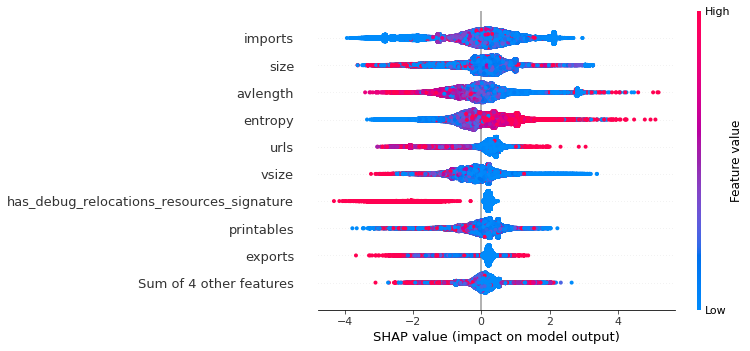

In [67]:
shap.plots.beeswarm(shap_values)

# Extract Results

In [20]:
# get predictions probabilities
y_test_pred = xgb_model.predict_proba(df_test[feature_cols])[:, 1]
y_train_pred = xgb_model.predict_proba(df_train[feature_cols])[:, 1]
# save to dataframes
df_test['pred'] = y_test_pred
df_train['pred'] = y_train_pred

In [31]:
# create results dataframe
train_results = df_train[['pred', 'label']]
test_results = df_test[['pred', 'label']]
# merge with vt_df
train_results = train_results.merge(vt_train_df, left_index=True, right_on='sha256',how='left')
test_results = test_results.merge(vt_test_df, left_index=True, right_on='sha256', how='left')

In [33]:
test_results.shape

(120000, 7)

In [35]:
train_results = train_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
test_results = test_results[['sha256', 'pred', 'label', 'num_undetected', 'num_malicious']]
train_results.to_csv('data/results/train_results.csv', index=False)
test_results.to_csv('data/results/test_results.csv', index=False)